In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import NeuralNets as NN_
#import NeuralNets_cython as NN
import pytorch_NN as PyNN
import pandas as pd

### Load dataset

In [2]:

#minst = pd.read_csv("mnist_train.csv").to_numpy()
minst = pd.read_csv("fashion-mnist_train.csv").to_numpy()
yactual_uncleaned = minst[:,0:1].flatten()
xactual = minst[:,1:]/255
yactual = np.zeros((60000,10))
for i,y in enumerate(yactual_uncleaned):
    yactual_temp = np.zeros(10)
    yactual_temp[y] = 1
    yactual[i] = yactual_temp


In [3]:
data_set  = PyNN.CustomDataset(xactual,yactual)
train,test = random_split(data_set,[int(.8 * len(data_set)),int(0.2 * len(data_set))])
num_epochs = 10
dataset_size = 60000
batch_size = 1000
data_loader_train = DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
data_loader_test = DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

In [4]:
## NN parameters
input_dim = 784
output_dim = 10
num_hidden_layers = 4
nodes_per_layer = 500
activation_fcn_ = "ReLU"
classifier_ = True

## Training parameters
optimizer_="ADAM"
minibatch_sz = batch_size
lr_ = .0001

## Simulation parameters
train_batch_percent = []
save_validation_history = True
use_tensors_=True
save_freq = 5 #epochs
save_val_freq = 10 #batches

## Temp values
small_number = 1e-15
CEL = 0
save_count = 0

In [5]:
## MY IMPLEMENTATION
tensor = NN_.FullyConnected(input_dim,output_dim,nodes_per_layer,num_hidden_layers,minibatch_sz,activation_fcn=activation_fcn_,optimizer=optimizer_,classifier=classifier_,use_tensors=use_tensors_)   

### MAIN LOOP

In [6]:

for epoch in range(0, num_epochs-1):
    batch_count = 0
    if epoch % save_freq == 0:
        NN_.save_state(test,"epoch"+str(epoch))
    
    for batch_x_train, batch_y_train in data_loader_train:
        ypred_train = tensor.forward(batch_x_train.numpy()).squeeze().T
        current_percent_correct = NN_.validate_data(ypred_train,batch_y_train.detach().numpy())
        tensor.gradient(ypred_train,batch_y_train.numpy(),batch_x_train.numpy())
        tensor.updateWeights(lr=lr_,alg=tensor.optimizer,clip_gradients = False)
        CEL = np.around(-np.mean(batch_y_train.numpy() * np.log(np.clip(ypred_train, small_number, 1 - small_number))),decimals=4)
        tensor.loss_history.append(CEL)
        print("[epoch: "+str(epoch)+" Batch: "+str(batch_count)+" ]  -----> Loss: "+str(CEL)+ "; Batch percent correct: "+str(current_percent_correct))
    
        if save_validation_history and save_count % save_val_freq==0:
            mean_percent_valid = 0
            mean_percent_train = 0
            for batch_x_train_, batch_y_train_ in data_loader_train:
                ypred_train_ = tensor.forward(batch_x_train_.numpy()).squeeze().T
                mean_percent_train += NN_.validate_data(ypred_train_,batch_y_train_.detach().numpy())/len(data_loader_train)
            for batch_x_test, batch_y_test in data_loader_test:
                ypred_validate = tensor.forward(batch_x_test.numpy()).squeeze().T
                mean_percent_valid += NN_.validate_data(ypred_validate,batch_y_test.detach().numpy())/len(data_loader_test)
            tensor.test_validation.append(mean_percent_valid)
            tensor.train_validation.append(mean_percent_train)
            print("\n TEST VALIDATION %---->  ",mean_percent_valid)
            print(" TRAIN VALIDATION %---->  ",mean_percent_train)
            print("")

        batch_count+=1
        save_count+=1
    
    

[epoch: 0 Batch: 0 ]  -----> Loss: 0.2332; Batch percent correct: 10.0

 TEST VALIDATION %---->   12.25
 TRAIN VALIDATION %---->   12.816666666666663

[epoch: 0 Batch: 1 ]  -----> Loss: 0.2309; Batch percent correct: 14.099999999999998
[epoch: 0 Batch: 2 ]  -----> Loss: 0.2295; Batch percent correct: 9.4
[epoch: 0 Batch: 3 ]  -----> Loss: 0.231; Batch percent correct: 11.4
[epoch: 0 Batch: 4 ]  -----> Loss: 0.2338; Batch percent correct: 12.1
[epoch: 0 Batch: 5 ]  -----> Loss: 0.2257; Batch percent correct: 15.4
[epoch: 0 Batch: 6 ]  -----> Loss: 0.2174; Batch percent correct: 13.8
[epoch: 0 Batch: 7 ]  -----> Loss: 0.212; Batch percent correct: 18.8
[epoch: 0 Batch: 8 ]  -----> Loss: 0.2047; Batch percent correct: 35.199999999999996
[epoch: 0 Batch: 9 ]  -----> Loss: 0.1894; Batch percent correct: 37.5
[epoch: 0 Batch: 10 ]  -----> Loss: 0.178; Batch percent correct: 32.1

 TEST VALIDATION %---->   29.608333333333334
 TRAIN VALIDATION %---->   30.060416666666665

[epoch: 0 Batch: 11 ]

KeyboardInterrupt: 

### Plot accuracy

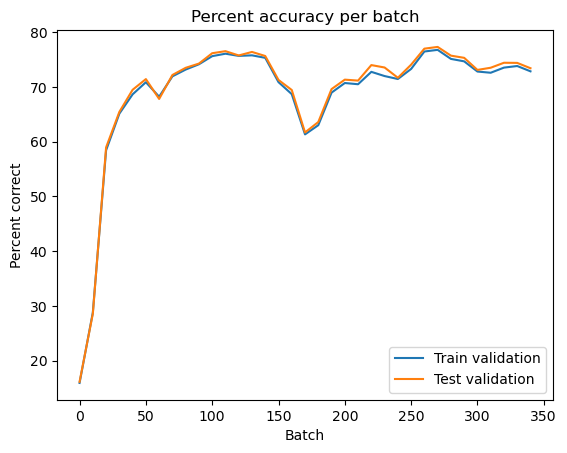

In [ ]:
plt.title("Percent accuracy per batch")
plt.xlabel("Batch")
plt.ylabel("Percent correct")
x = np.arange(len(tensor.train_validation))*save_val_freq
plt.plot(x,tensor.train_validation)
plt.plot(x,tensor.test_validation)
plt.legend(["Train validation", "Test validation"])

### Plot loss

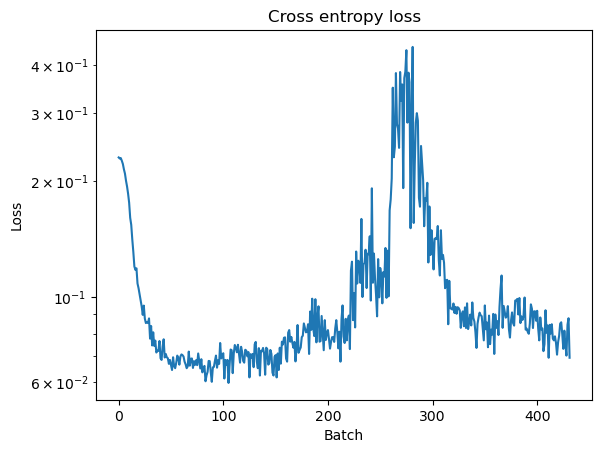

In [ ]:
plt.title("Cross entropy loss")
plt.ylabel("Loss")
plt.xlabel("Batch")

plt.semilogy(tensor.loss_history)

### Quick sanity check...

NN predicted number:  4


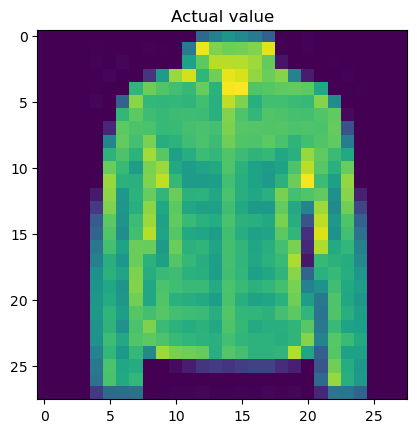

In [ ]:

x = 19
vec = (batch_x_train[x].numpy()*255).astype(int)
print("NN predicted number: ", np.argmax(ypred_train[x]))
matrix = vec.reshape(28,28)
plt.imshow(matrix)
plt.title("Actual value")
plt.show()